<a href="https://colab.research.google.com/github/SamaSamrin/Mixed-Example-Data-Augmentation-Project/blob/main/ham10000_mixed_example_unet_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# U-Net Training on HAM10000 Dataset with Mixed Example Augmentation
Note: The model training and validation in this notebook is performed using subset of 1000 images from complete dataset.


### Google Drive Mounting

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Utilities

In [ ]:
import os
import cv2 as cv
import numpy as np
import random
import math
from tqdm import tqdm
import gc
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras import models

### U-Net Builder Installation
The keras-unet-collection is a library to initiate U-Net image segmentation model  based on Tensorflow.



In [ ]:
!pip install keras-unet-collection

### Build U-Net Model

In [ ]:
from keras_unet_collection import models
from tensorflow.keras import optimizers

# Shape of input image
input_size = (256, 256, 3)
# Number of output (mask) layers
n_class = 1

# Initialize the model
model = models.unet_2d(input_size, filter_num=[64, 128, 256, 512, 1024], n_labels=n_class,
                           stack_num_down=2, stack_num_up=2, activation='ReLU', output_activation='Sigmoid',
                           batch_norm=True,
                           backbone='VGG16',
                           weights='imagenet',
                           name='unet')


# Compile the model with adam optimizer and 0.001 learning rate
model.compile(optimizer = optimizers.Adam (learning_rate = 1e-3), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
# Print the architecture of the model
model.summary()

### Data Generator
Define a data generator class to fetch the data to the segmentation model during training. The transformation functions are implemented here.

In [ ]:
import random

class DataGen(tf.keras.utils.Sequence):
  # The class inherited must implement __len__, __getitem__ methods

  def __init__(self, x_set, y_set, batch_size, transform_mode='', training=True, always_augment=False):
    # x_set is a list of image path to training images
    self.x = x_set
    self.y = y_set
    # Number of images to feed per batch during training
    self.batch_size = batch_size
    self.transform_mode = transform_mode
    # Training or validation
    self.training = training
    self.always_augment = always_augment

  def __len__(self):
    # Returns the number of batch the generator will produce
    return math.ceil(len(self.x) / self.batch_size)

  def v_concat(self, sample_1, sample_2):
    v_concat_img = cv.vconcat([sample_1, sample_2])
    return v_concat_img

  def h_concat(self, sample_1, sample_2):
    h_concat_img = cv.hconcat([sample_1, sample_2])
    return h_concat_img

  def mix_concat(self, sample_1, sample_2):
    # horizontally concatenate the 2 images first, switching one for the other each time
    first_h_concat = cv.hconcat([sample_1, sample_2])
    second_h_concat = cv.hconcat([sample_2, sample_1])
    # now vertically concatenate the 2 resulting images
    mixed_concat_image = cv.vconcat([first_h_concat, second_h_concat])
    return mixed_concat_image

  def mixup(self, sample_1, sample_2, seed_1):
    tf.random.set_seed(seed_1)
    mix_coeff = tf.random.uniform([])
    mixup_image = mix_coeff * sample_1 + (1 - mix_coeff) * sample_2
    mixup_image = mixup_image.numpy()
    return mixup_image

  def noisy_mixup(self, sample_1, sample_2, seed_1, seed_2):
    (H, W, C) = sample_1.shape
    tf.random.set_seed(seed_1)
    mix_coeff = tf.random.uniform([])
    tf.random.set_seed(seed_2)
    mix_mat = tf.random.normal([W, H, 1], mix_coeff, 0.025)
    mix_mat = tf.maximum(tf.minimum(mix_mat, 1.), 0.)
    noisy_mixup_image = mix_mat * sample_1 + (1 - mix_mat) * sample_2
    noisy_mixup_image = noisy_mixup_image.numpy()
    return (noisy_mixup_image)

  def random_2x2(self, sample_1, sample_2, seed_1, seed_2, seed_3, seed_4):
    (H, W, C) = sample_1.shape
    p = 0.5
    h_buff = int(round(.5 * p * H))
    w_buff = int(round(.5 * p * W))
    tf.random.set_seed(seed_1)
    dim_H = tf.random.uniform([], h_buff, H - h_buff, dtype=tf.int32)
    tf.random.set_seed(seed_2)
    dim_W = tf.random.uniform([], w_buff, W - w_buff, dtype=tf.int32)
    lambda_H = dim_H / H
    lambda_W = dim_W / W
    tf.random.set_seed(seed_3)
    random_3 = tf.random.uniform([4])
    tf.random.set_seed(seed_4)
    random_4 = tf.random.uniform([])
    rand_vals = tf.compat.v1.to_float(random_3 < random_4)
    mask =  tf.concat([
      tf.concat([tf.fill([dim_H, dim_W], rand_vals[0]),
                tf.fill([dim_H, W-dim_W], rand_vals[1])], axis=1),
      tf.concat([tf.fill([H-dim_H, dim_W], rand_vals[2]),
                tf.fill([H-dim_H, W-dim_W], rand_vals[3])], axis=1)],
      axis=0)
    mask = tf.expand_dims(mask, 2)
    image_rand_2x2 = mask * sample_1 + (1. - mask) * sample_2
    image_rand_2x2 = image_rand_2x2.numpy()
    return (image_rand_2x2)

  def vh_bcplus(self, sample_1, sample_2, seed_1):
    v_concat_img = self.v_concat(sample_1, sample_2)
    v_concat_img = cv.resize(v_concat_img, (256,256))
    #v_concat_img = np.expand_dims(v_concat_img, 2)
    h_concat_img = self.h_concat(sample_1, sample_2)
    h_concat_img = cv.resize(h_concat_img, (256,256))
    #h_concat_img = np.expand_dims(h_concat_img, 2)
    tf.random.set_seed(seed_1)
    mix_coeff = tf.random.uniform([])
    mean0, var0 = tf.nn.moments(v_concat_img, axes=None)
    std0 = tf.math.sqrt(var0)
    mean1, var1 = tf.nn.moments(h_concat_img, axes=None)
    std1 = tf.math.sqrt(var1)
    p = 1. / (1. + (std0 / std1) * (1. - mix_coeff) / mix_coeff)
    bcplus_image = (p * v_concat_img + (1. - p) * h_concat_img) / tf.math.sqrt(tf.math.pow(p, 2) + tf.math.pow(1-p, 2))
    return bcplus_image.numpy()

  def random_square(self, sample_1, sample_2, seed_1, seed_2):
    (H, W, C) = sample_1.shape
    def random_square_np(sample_1, sample_2):
      square_length = 16
      np.random.seed(seed_1)
      center_r = np.random.randint(0, H)
      np.random.seed(seed_2)
      center_c = np.random.randint(0, W)
      r1 = int(max(center_r - square_length / 2, 0))
      r2 = int(min(center_r + square_length / 2, H))
      c1 = int(max(center_c - square_length / 2, 0))
      c2 = int(min(center_c + square_length / 2, W))
      image = sample_1.numpy().copy()
      square_frac = float(r2 - r1) * (c2 - c1) / (H * W)
      r1_2 = np.random.randint(0, H - (r2 - r1))
      r2_2 = r1_2 + (r2 - r1)
      c1_2 = np.random.randint(0, W - (c2 - c1))
      c2_2 = c1_2 + (c2 - c1)
      image[r1:r2,c1:c2,:] = sample_2[r1_2:r2_2,c1_2:c2_2,:]
      return image
    image = tf.py_function(random_square_np, [sample_1, sample_2], tf.float32, name='random_square')
    return (image.numpy())

  def random_row_interval(self, sample_1, sample_2, seed_1, seed_2, seed_3):
    (H, W, C) = sample_1.shape
    tf.random.set_seed(seed_1)
    ind1 = tf.random.uniform([], 0, H, dtype=tf.int32)
    tf.random.set_seed(seed_2)
    ind2 = tf.random.uniform([], ind1, H, dtype=tf.int32)
    length = ind2 - ind1
    tf.random.set_seed(seed_3)
    ind3 = tf.random.uniform([], 0, H-length, dtype=tf.int32)
    ind4 = ind3 + length
    image = tf.concat([sample_1[:ind1, :, :],
                      sample_2[ind3:ind4, :, :],
                      sample_1[ind2:, :, :]], axis=0)
    return image.numpy()

  def random_column_interval(self, sample_1, sample_2, seed_1, seed_2, seed_3):
    (H, W, C) = sample_1.shape
    tf.random.set_seed(seed_1)
    ind1 = tf.random.uniform([], 0, W, dtype=tf.int32)
    tf.random.set_seed(seed_2)
    ind2 = tf.random.uniform([], ind1, W, dtype=tf.int32)
    length = ind2 - ind1
    tf.random.set_seed(seed_3)
    ind3 = tf.random.uniform([], 0, W-length, dtype=tf.int32)
    ind4 = ind3 + length
    image = tf.concat([sample_1[:, :ind1, :],
                      sample_2[:, ind3:ind4, :],
                      sample_1[:, ind2:, :]], axis=1)
    return image.numpy()

  def random_rows(self, sample_1, sample_2, seed_1, seed_2):
    (H, W, C) = sample_1.shape
    tf.random.set_seed(seed_1)
    random_1 = tf.random.uniform([H, 1, 1])
    tf.random.set_seed(seed_2)
    random_2 = tf.random.uniform([])
    mask = tf.compat.v1.to_float(random_1 < random_2)
    image = mask * sample_1 + (1 - mask) * sample_2
    return image.numpy()

  def random_cols(self, sample_1, sample_2, seed_1, seed_2):
    (H, W, C) = sample_1.shape
    tf.random.set_seed(seed_1)
    random_1 = tf.random.uniform([1, W, 1])
    tf.random.set_seed(seed_2)
    random_2 = tf.random.uniform([])
    mask = tf.compat.v1.to_float(random_1 < random_2)
    image = mask * sample_1 + (1 - mask) * sample_2
    return image.numpy()

  def random_pixels(self, sample_1, sample_2, seed_1, seed_2):
    (H, W, C) = sample_1.shape
    tf.random.set_seed(seed_1)
    random_1 = tf.random.uniform([H, W, 1])
    tf.random.set_seed(seed_2)
    random_2 = tf.random.uniform([])
    mask = tf.compat.v1.to_float(random_1  < random_2)
    image = mask * sample_1 + (1 - mask) * sample_2
    return image.numpy()

  def random_elems(self, sample_1, sample_2, seed_1, seed_2):
    (H, W, C) = sample_1.shape
    tf.random.set_seed(seed_1)
    random_1 = tf.random.uniform([H, W, C])
    tf.random.set_seed(seed_2)
    random_2 = tf.random.uniform([])
    mask = tf.compat.v1.to_float(random_1 < random_2)
    image = mask * sample_1 + (1 - mask) * sample_2
    return image.numpy()



  def __getitem__(self, idx):
    # Feed a batch of images (x) and mask (y) to the model during training and validation.
    # The images (x) and labels (y) are preprocessed here.

    low = idx * self.batch_size
    # Cap upper bound at array length; the last batch may be smaller
    # if the total number of items is not a multiple of batch size.
    high = min(low + self.batch_size, len(self.x))
    batch_x = self.x[low:high]
    batch_y = self.y[low:high]

    # Placeholder for images (x) and labels (y)
    x=[] ; y=[]

    if self.training:
      # Perform random interval augmentation during training
      to_augment = random.randint(0,1)
    else:
      # Dont augment if not in training
      to_augment = 0

    if self.always_augment:
      # for testing the transformation function
      to_augment = 1

    if to_augment==1 and self.transform_mode!='':
      # Training mode

      # Random seed
      random_seed_1 = random.randint(0,10)
      random_seed_2 = random.randint(0,10)
      random_seed_3 = random.randint(0,10)
      random_seed_4 = random.randint(0,10)

      # Random index for image 1
      random_index_1 = random.randint(0, len(batch_x)-1)
      # Random index for image 2
      while True:
        random_index_2 = random.randint(0, len(batch_x)-1)
        if random_index_2 != random_index_1:
          break

      # Input RGB Image
      for _ in range(len(batch_x)):
        ...
        # Image 1
        input_img_1 = cv.imread(batch_x[random_index_1])
        input_img_1 = cv.resize(input_img_1, (256,256))
        input_img_1 = cv.normalize(input_img_1, None, 0,1,cv.NORM_MINMAX, cv.CV_32F)
        # Image 2
        input_img_2 = cv.imread(batch_x[random_index_2])
        input_img_2 = cv.resize(input_img_2, (256,256))
        input_img_2 = cv.normalize(input_img_2, None, 0,1,cv.NORM_MINMAX, cv.CV_32F)
        # TRANSFORM
        if self.transform_mode == 'v_concat':
          input_img = self.v_concat(input_img_1, input_img_2)
          input_img = cv.resize(input_img, (256,256))
          input_img = input_img[:,:,::-1]
          x.append(input_img)
        elif self.transform_mode == 'h_concat':
          input_img = self.h_concat(input_img_1, input_img_2)
          input_img = cv.resize(input_img, (256,256))
          input_img = input_img[:,:,::-1]
          x.append(input_img)
        elif self.transform_mode == 'mix_concat':
          input_img = self.mix_concat(input_img_1, input_img_2)
          input_img = cv.resize(input_img, (256,256))
          input_img = input_img[:,:,::-1]
          x.append(input_img)
        elif self.transform_mode == 'mixup':
          input_img = self.mixup(input_img_1, input_img_2, random_seed_1)
          input_img = cv.resize(input_img, (256,256))
          input_img = input_img[:,:,::-1]
          x.append(input_img)
        elif self.transform_mode == 'noisy_mixup':
          input_img = self.noisy_mixup(input_img_1, input_img_2, random_seed_1, random_seed_2)
          input_img = cv.resize(input_img, (256,256))
          input_img = input_img[:,:,::-1]
          x.append(input_img)
        elif self.transform_mode == 'random_2x2':
          input_img = self.random_2x2(input_img_1, input_img_2, random_seed_1, random_seed_2, random_seed_3, random_seed_4)
          input_img = cv.resize(input_img, (256,256))
          input_img = input_img[:,:,::-1]
          x.append(input_img)
        elif self.transform_mode == 'vh_bcplus':
          input_img = self.vh_bcplus(input_img_1, input_img_2, random_seed_1)
          input_img = cv.resize(input_img, (256,256))
          input_img = input_img[:,:,::-1]
          x.append(input_img)
        elif self.transform_mode == 'random_square':
          input_img = self.random_square(input_img_1, input_img_2, random_seed_1, random_seed_2)
          input_img = cv.resize(input_img, (256,256))
          input_img = input_img[:,:,::-1]
          x.append(input_img)
        elif self.transform_mode == 'random_row_interval':
          input_img = self.random_row_interval(input_img_1, input_img_2, random_seed_1, random_seed_2, random_seed_3)
          input_img = cv.resize(input_img, (256,256))
          input_img = input_img[:,:,::-1]
          x.append(input_img)
        elif self.transform_mode == 'random_column_interval':
          input_img = self.random_column_interval(input_img_1, input_img_2, random_seed_1, random_seed_2, random_seed_3)
          input_img = cv.resize(input_img, (256,256))
          input_img = input_img[:,:,::-1]
          x.append(input_img)
        elif self.transform_mode == 'random_rows':
          input_img = self.random_rows(input_img_1, input_img_2, random_seed_1, random_seed_2)
          input_img = cv.resize(input_img, (256,256))
          input_img = input_img[:,:,::-1]
          x.append(input_img)
        elif self.transform_mode == 'random_cols':
          input_img = self.random_cols(input_img_1, input_img_2, random_seed_1, random_seed_2)
          input_img = cv.resize(input_img, (256,256))
          input_img = input_img[:,:,::-1]
          x.append(input_img)
        elif self.transform_mode == 'random_pixels':
          input_img = self.random_pixels(input_img_1, input_img_2, random_seed_1, random_seed_2)
          input_img = cv.resize(input_img, (256,256))
          input_img = input_img[:,:,::-1]
          x.append(input_img)
        elif self.transform_mode == 'random_elems':
          input_img = self.random_elems(input_img_1, input_img_2, random_seed_1, random_seed_2)
          input_img = cv.resize(input_img, (256,256))
          input_img = input_img[:,:,::-1]
          x.append(input_img)

      # Mask Label
      for _ in batch_y:
        ...
        # Mask 1
        mask_1 = cv.imread(batch_y[random_index_1], 0)
        mask_1 = cv.resize(mask_1, (256,256))
        mask_1 = cv.normalize(mask_1, None, 0,1,cv.NORM_MINMAX, cv.CV_32F)
        mask_1 = np.expand_dims(mask_1,2)
        # Mask 2
        mask_2 = cv.imread(batch_y[random_index_2], 0)
        mask_2 = cv.resize(mask_2, (256,256))
        mask_2 = cv.normalize(mask_2, None, 0,1,cv.NORM_MINMAX, cv.CV_32F)
        mask_2 = np.expand_dims(mask_2,2)
        # TRANSFORM
        if self.transform_mode =='v_concat':
          mask = self.v_concat(mask_1, mask_2)
          mask = cv.resize(mask, (256,256))
        elif self.transform_mode =='h_concat':
          mask = self.h_concat(mask_1, mask_2)
          mask = cv.resize(mask, (256,256))
        elif self.transform_mode =='mix_concat':
          mask = self.mix_concat(mask_1, mask_2)
          mask = cv.resize(mask, (256,256))
        elif self.transform_mode =='mixup':
          mask = self.mixup(mask_1, mask_2, random_seed_1)
          mask = cv.resize(mask, (256,256))
        elif self.transform_mode =='noisy_mixup':
          mask = self.noisy_mixup(mask_1, mask_2, random_seed_1, random_seed_2)
          mask = cv.resize(mask, (256,256))
        elif self.transform_mode =='random_2x2':
          mask = self.random_2x2(mask_1, mask_2, random_seed_1, random_seed_2, random_seed_3, random_seed_4)
          mask = cv.resize(mask, (256,256))
        elif self.transform_mode =='vh_bcplus':
          mask = self.vh_bcplus(mask_1, mask_2, random_seed_1)
          mask = cv.resize(mask, (256,256))
        elif self.transform_mode =='random_square':
          mask = self.random_square(mask_1, mask_2, random_seed_1, random_seed_2)
          mask = cv.resize(mask, (256,256))
        elif self.transform_mode =='random_row_interval':
          mask = self.random_row_interval(mask_1, mask_2, random_seed_1, random_seed_2, random_seed_3)
          mask = cv.resize(mask, (256,256))
        elif self.transform_mode =='random_column_interval':
          mask = self.random_column_interval(mask_1, mask_2, random_seed_1, random_seed_2, random_seed_3)
          mask = cv.resize(mask, (256,256))
        elif self.transform_mode =='random_rows':
          mask = self.random_rows(mask_1, mask_2, random_seed_1, random_seed_2)
          mask = cv.resize(mask, (256,256))
        elif self.transform_mode =='random_cols':
          mask = self.random_cols(mask_1, mask_2, random_seed_1, random_seed_2)
          mask = cv.resize(mask, (256,256))
        elif self.transform_mode =='random_pixels':
          mask = self.random_pixels(mask_1, mask_2, random_seed_1, random_seed_2)
          mask = cv.resize(mask, (256,256))
        elif self.transform_mode =='random_elems':
          mask = self.random_elems(mask_1, mask_2, random_seed_1, random_seed_2)
          mask = cv.resize(mask, (256,256))
        ...
        y.append(mask)


    else:
      # Validation mode

      # Image
      for x_path in batch_x:
        input_img = cv.imread(x_path)
        input_img = cv.resize(input_img, (256,256))
        input_img = input_img[:,:,::-1]
        input_img = cv.normalize(input_img, None, 0,1,cv.NORM_MINMAX, cv.CV_32F)
        x.append(input_img)

      # Mask Label
      for y_path in batch_y:
        mask = cv.imread(y_path, 0)
        mask = cv.resize(mask, (256,256))
        mask = cv.normalize(mask, None, 0,1,cv.NORM_MINMAX, cv.CV_32F)
        #mask = np.expand_dims(mask,2)
        y.append(mask)

    # Make x and y as numpy array
    x = np.asarray(x)
    y = np.asarray(y)

    return x, y

### Specify Data Source
Skip if Pickle files already present

In [ ]:
# Path to data files to be used for training
x_dir = '/content/drive/MyDrive/Colab Notebooks/skin_cancer_classification/dataset/train/'
y_dir = '/content/drive/MyDrive/Colab Notebooks/skin_cancer_classification/dataset/masks/'

# Placeholder for file path
x_paths = []
y_paths = []

x_files = os.listdir(x_dir)
for x_file in tqdm(x_files[:1000]):
  y_file = f'{os.path.splitext(x_file)[0]}_segmentation.png'
  y_path = os.path.join(y_dir, y_file)
  if cv.imread(y_path) is not None:
    x_paths.append(os.path.join(x_dir, x_file))
    y_paths.append(os.path.join(y_dir, y_file))
  else:
    # File does not exist
    continue

# Split data for training and validation. The training data is 80% of the files and validation is 20% of the files.
x_train = x_paths[:int(len(x_paths)*0.8)]
x_val = x_paths[int(len(x_paths)*0.8):]
y_train = y_paths[:int(len(y_paths)*0.8)]
y_val = y_paths[int(len(y_paths)*0.8):]

100%|██████████| 1000/1000 [00:02<00:00, 370.64it/s]


### Specify Data Source from Saved Pickle File (faster alternate to previous cell)

In [ ]:
import pickle
#pickle.dump(x_paths,open("/content/drive/MyDrive/Colab Notebooks/skin_cancer_classification/x_paths.p", "wb"))
#pickle.dump(y_paths,open("/content/drive/MyDrive/Colab Notebooks/skin_cancer_classification/y_paths.p", "wb"))
#x_paths = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/skin_cancer_classification/x_paths.p","rb"))
#y_paths = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/skin_cancer_classification/y_paths.p","rb"))
# Split data for training and validation. The training data is 80% of the files and validation is 20% of the files.
#x_train = x_paths[:int(len(x_paths)*0.8)]
#x_val = x_paths[int(len(x_paths)*0.8):]
#y_train = y_paths[:int(len(y_paths)*0.8)]
#y_val = y_paths[int(len(y_paths)*0.8):]

### Testing Transformation Output

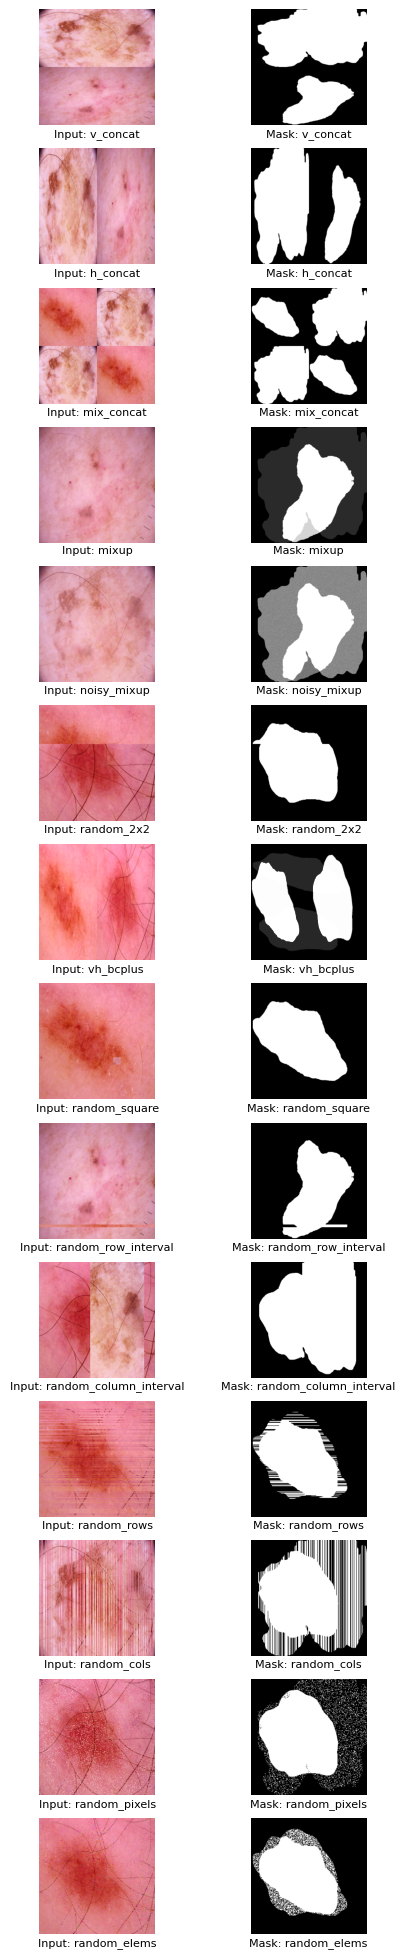

In [ ]:
# Transformation mode
transform_mode = ['v_concat', 'h_concat', 'mix_concat', 'mixup', 'noisy_mixup', 'random_2x2', 'vh_bcplus', 'random_square', 'random_row_interval',
                  'random_column_interval', 'random_rows', 'random_cols', 'random_pixels', 'random_elems']

# Number of images / labels to feed on each batch during traning.
batch_size = 4

imgs = []
masks = []

for mode in transform_mode:
  test_gen = DataGen(x_set=x_paths, y_set=y_paths, batch_size=batch_size, transform_mode=mode, always_augment=True)
  # Get first generated RGB image (x) and label mask (y)
  x, y = test_gen.__getitem__(0)
  imgs.append(x[0])
  masks.append(y[0])

# Visualizing

fig, ax = plt.subplots(len(transform_mode), 2, figsize=(5,25))

for i in range(len(transform_mode)):
  # Plot test image
  ax[i,0].axis('off')
  ax[i,0].set_title(f'Input: {transform_mode[i]}', y=0, pad=-2, verticalalignment='top', fontsize=8)
  ax[i,0].imshow((imgs[i]), vmin=0, vmax=1)
  # Plot model A prediction
  ax[i,1].axis('off')
  ax[i,1].set_title(f'Mask: {transform_mode[i]}', y=0, pad=-2, verticalalignment='top', fontsize=8)
  ax[i,1].imshow((masks[i]), vmin=0, vmax=1, cmap='gray')

### Initialize Data Generator Object for Training and Validation

In [ ]:
# Transformation mode
transform_mode = ['v_concat', 'h_concat', 'mix_concat', 'mixup', 'noisy_mixup', 'random_2x2', 'vh_bcplus', 'random_square', 'random_row_interval',
                  'random_column_interval', 'random_rows', 'random_cols', 'random_pixels', 'random_elems']

# Number of images / labels to feed on each batch during traning.
batch_size = 4

# Training data generator. Select transform mode from above list
train_gen = DataGen(x_set=x_train, y_set=y_train, batch_size=batch_size, transform_mode=transform_mode[0], training=True)
# Validation data generator. No transformation
val_gen = DataGen(x_set=x_val, y_set=y_val, batch_size=batch_size, training=False)

### Verify Training Data Generator

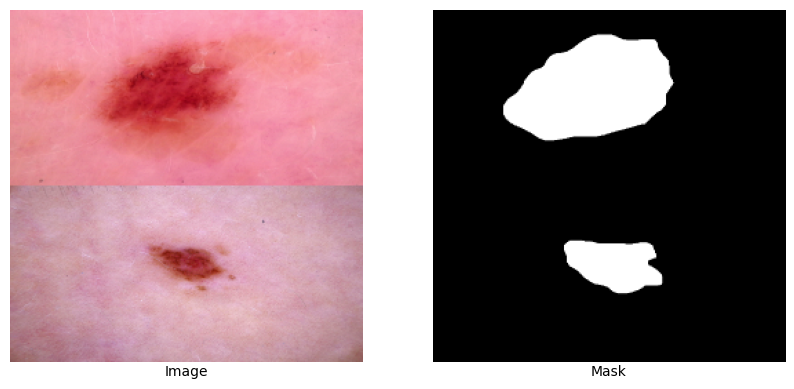

In [ ]:
from matplotlib import pyplot as plt

# Get first generated RGB image (x) and label mask (y)
x, y = train_gen.__getitem__(1)

img = x[0]
mask = y[0]

# Visualize it
fig, ax = plt.subplots(1,2,figsize=(10,15))
ax[0].axis('off')
ax[0].set_title('Image', y=0, pad=-2, verticalalignment='top', fontsize=10)
ax[0].imshow(img, vmin=0, vmax=1)

ax[1].axis('off')
ax[1].set_title('Mask', y=0, pad=-2, verticalalignment='top', fontsize=10)
ax[1].imshow(mask, cmap = 'gray', vmin=0, vmax=1)

### Run the Training

In [ ]:
# Checkpoint path
checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/skin_cancer_classification/unet-ep-1.h5"
# Number of epoch (iteration) for training
n_epochs = 1

# Run the training
results = model.fit(train_gen, validation_data = val_gen, epochs = n_epochs)

# Save the trained model to a file
model.save(checkpoint_path)

### Retrain

In [ ]:
from tensorflow.keras import models

# Load trained model
model_name = "/content/drive/MyDrive/Colab Notebooks/skin_cancer_classification/unet-ep-1.h5"
# Checkpoint path
checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/skin_cancer_classification/unet-ep-2.h5"

model = models.load_model(model_name)

# Number of epoch (iteration) for training
n_epochs = 1

# Compile the model with adam optimizer and 0.0001 learning rate
model.compile(optimizer = optimizers.Adam (learning_rate = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
# Run the training
results = model.fit(train_gen, validation_data = val_gen, epochs = n_epochs)
# Save the trained model to a file
model.save(checkpoint_path)

### Prediction Test with Sample Test Images from Dataset

1/1 [==============================] - 1s 1s/step
---Metrics---
Mean Accuracy: 0.7206634521484375
Mean Precision: 0.46667019503269397
Mean Recall: 0.8521296080682408
Mean F1: 0.5856385637272751


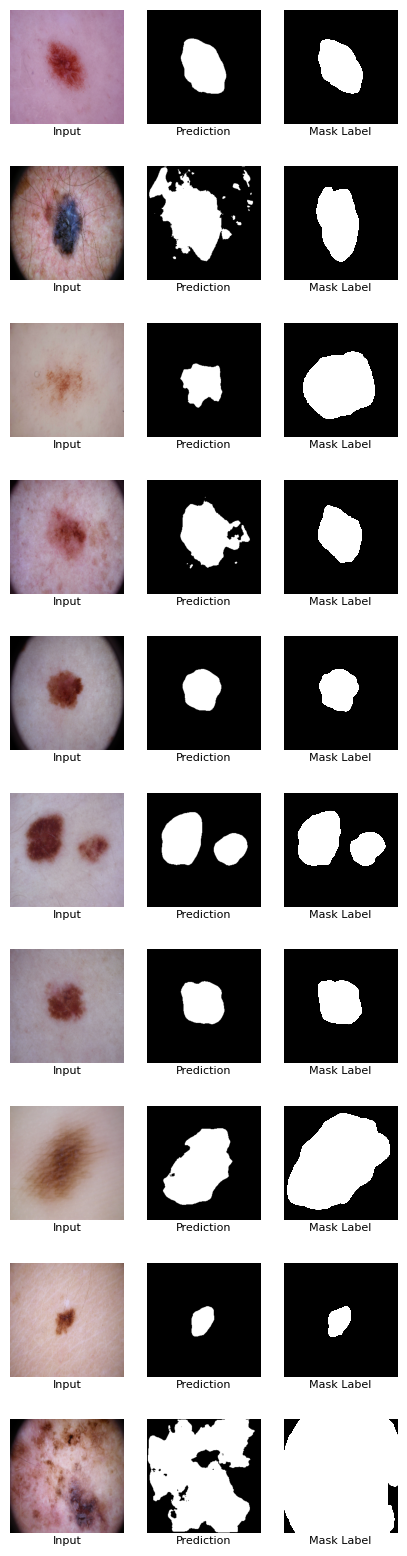

In [ ]:
# Path to model to test
model_path = "/content/drive/MyDrive/Colab Notebooks/skin_cancer_classification/checkpoints/unet-ep-3.h5"
#model_path = "/content/drive/MyDrive/Colab Notebooks/skin_cancer_classification/checkpoints/unet-h_concat-ep-3.h5"
#model_path = "/content/drive/MyDrive/Colab Notebooks/skin_cancer_classification/checkpoints/unet-v_concat-ep-3.h5"
#model_path = "/content/drive/MyDrive/Colab Notebooks/skin_cancer_classification/checkpoints/unet-mix_concat-ep-3.h5"
#model_path = "/content/drive/MyDrive/Colab Notebooks/skin_cancer_classification/checkpoints/unet-mixup-ep-3.h5"
#model_path = "/content/drive/MyDrive/Colab Notebooks/skin_cancer_classification/checkpoints/unet-noisy_mixup-ep-3.h5"
#model_path = "/content/drive/MyDrive/Colab Notebooks/skin_cancer_classification/checkpoints/unet-random_2x2-ep-3.h5"
#model_path = "/content/drive/MyDrive/Colab Notebooks/skin_cancer_classification/checkpoints/unet-vh_bcplus-ep-3.h5"
#model_path = "/content/drive/MyDrive/Colab Notebooks/skin_cancer_classification/checkpoints/unet-random_square-ep-3.h5"
#model_path = "/content/drive/MyDrive/Colab Notebooks/skin_cancer_classification/checkpoints/unet-random_row_interval-ep-3.h5"
#model_path = "/content/drive/MyDrive/Colab Notebooks/skin_cancer_classification/checkpoints/unet-random_column_interval-ep-3.h5"
#model_path = "/content/drive/MyDrive/Colab Notebooks/skin_cancer_classification/checkpoints/unet-random_rows-ep-3.h5"
#model_path = "/content/drive/MyDrive/Colab Notebooks/skin_cancer_classification/checkpoints/unet-random_cols-ep-3.h5"
#model_path = "/content/drive/MyDrive/Colab Notebooks/skin_cancer_classification/checkpoints/unet-random_pixels-ep-3.h5"
#model_path = "/content/drive/MyDrive/Colab Notebooks/skin_cancer_classification/checkpoints/unet-random_elems-ep-3.h5"

# Path to test images and masks
test_images_dir = '/content/drive/MyDrive/Colab Notebooks/skin_cancer_classification/dataset/test/'
test_masks_dir = '/content/drive/MyDrive/Colab Notebooks/skin_cancer_classification/dataset/masks/'

# Number of random test images
n_test_images = 10

# Get list of paths of test images
test_images_paths = []
file_names = os.listdir(test_images_dir)
for file_name in file_names:
  test_images_paths.append(os.path.join(test_images_dir, file_name))

# Random seed for reproducible random
random_seed = 3
random.seed(random_seed)

# Random test images index
test_images_idx = []
for i in range (n_test_images):
  test_images_idx.append(random.randint(0, len(test_images_paths)-1))

# Prediction threshold
pred_th = 0.3

# Reading test images and masks
test_images = []
test_masks = []

for idx in test_images_idx:
  # Read and preprocess the image
  img = cv.imread(test_images_paths[idx])
  img = img[:,:,::-1]
  img = cv.resize(img, (256,256))
  img = img/255
  test_images.append(img)
  # Masks
  mask_file_name = f'{os.path.splitext(os.path.split(test_images_paths[idx])[-1])[0]}_segmentation.png'
  mask = cv.imread(os.path.join(test_masks_dir, mask_file_name), 0)
  mask = cv.resize(mask, (256,256))
  test_masks.append(mask)

# Placeholder for results
pred_results = []

# Loading the model
model = models.load_model(model_path)

# Perform prediciton to test images
for img in test_images:

  # Reshape the image
  img = np.reshape(img,(1,256,256,3))
  # Predict
  preds = model.predict(img, verbose=1)
  pred = (preds[0])
  # Thresholding to form binary image
  _, pred = cv.threshold(pred, pred_th, 1, cv.THRESH_BINARY)

  pred_results.append(pred)

  del preds
  del pred
  gc.collect()


# Visualize Prediction
fig, ax = plt.subplots(n_test_images, 3, figsize=(5,20))

for i in range(n_test_images):

  # Plot test image
  ax[i,0].axis('off')
  ax[i,0].set_title('Input', y=0, pad=-2, verticalalignment='top', fontsize=8)
  ax[i,0].imshow((test_images[i]), vmin=0, vmax=1)

  # Plot model prediction
  ax[i,1].axis('off')
  ax[i,1].set_title('Prediction', y=0, pad=-2, verticalalignment='top', fontsize=8)
  ax[i,1].imshow((pred_results[i]), vmin=0, vmax=1, cmap='gray')

  # Plot test image
  ax[i,2].axis('off')
  ax[i,2].set_title('Mask Label', y=0, pad=-2, verticalalignment='top', fontsize=8)
  ax[i,2].imshow((test_masks[i]), vmin=0, vmax=1, cmap='gray')


## METRICS CALCULATION
def calculate_metrics(pred, mask):

  # mask = np.squeeze(mask)
  # True +, True -, False +, False -
  TP = tf.math.count_nonzero(pred * mask)
  TN = tf.math.count_nonzero((pred - 1) * (mask - 1))
  FP = tf.math.count_nonzero(pred * (mask - 1))
  FN = tf.math.count_nonzero((pred - 1) * mask)

  # Accuracy
  acc = tf.keras.metrics.Accuracy()
  acc.update_state(mask, pred)
  accuracy = acc.result().numpy()

  # Precision
  if TP == 0:
    precision = 0
  else:
    precision = (TP / (TP + FP)).numpy()

  # Recall
  if TP == 0:
    recall = 0
  else:
    recall = (TP / (TP + FN)).numpy()

  # F1
  if (precision+recall) == 0:
    f1 = 0
  else:
    f1 = 2 * precision * recall / (precision + recall)

  return [accuracy, precision, recall, f1]


def calculate_mean_metrics(preds, masks):

  # Placeholder for metrics
  metrics = []

  for i in range(len(preds)):
    metrics.append(calculate_metrics(preds[i], masks[i]))

  # Calculate mean metrics
  accuracy_total = 0
  precision_total = 0
  recall_total = 0
  f1_total = 0

  for metric in metrics:
    accuracy_total += metric[0]
    precision_total += metric[1]
    recall_total += metric[2]
    f1_total += metric[3]

  mean_metrics = [accuracy_total/len(metrics),
                  precision_total/len(metrics),
                  recall_total/len(metrics),
                  f1_total/len(metrics)]

  return mean_metrics

# Mean metrics
mean_metrics = calculate_mean_metrics(pred_results, test_masks)

print ('---Metrics---')
print (f'Mean Accuracy: {mean_metrics[0]}')
print (f'Mean Precision: {mean_metrics[1]}')
print (f'Mean Recall: {mean_metrics[2]}')
print (f'Mean F1: {mean_metrics[3]}')